## Introduction 

Dans ce TP, nous avons mis en place une méthode d'alignement de points caractéristiques du visage en utilisant une cascade de régresseurs. Nous avons utilisé une base de données d'images de visages et d'annotations des points caractéristiques de ces visages pour entraîner et évaluer notre méthode. Nous avons préparé ces données en les visualisant et en les augmentant en générant des perturbations aléatoires de la position des points caractéristiques. Nous avons ensuite mis en place et entraîné notre cascade de régresseurs pour l'alignement des points caractéristiques et évalué la qualité de l'alignement obtenu. Dans ce rapport, nous présenterons les détails de notre implémentation ainsi que les résultats obtenus et une analyse critique de notre méthode.

Les questions sont reportées dans le notebook pour faciliter la correction au correcteur.


# Télechargement des données

In [1]:

import os

if not os.path.isdir("data"):
    os.mkdir("data")
    !wget https://cloud.isir.upmc.fr/owncloud/index.php/s/WMiMAF4aQqjoZWe/download -O data/download.zip
    !unzip -qq data/download.zip -d data
    !rm data/download.zip


# Parsing 300w_train_images.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2 as cv
import glob


def parsepts(path):
  if path[-4:] != '.pts':
    path = to_pts(path)

  with open(path, 'r') as f:
    for i, line in enumerate(f) :
      if i == 0 :
        pts = str2int(line.strip().split(" ")).reshape([1,2])
      else:
        pts = np.concatenate((pts, str2int(line.strip().split(" ")).reshape([1,2])), axis = 0)
    
  return pts

def load_img(path , rgb = True):
  im = cv.imread(path.strip())
  if rgb:
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB) 

  return im

def to_pts(img_path):
  point_index = img_path.index(".")

  return img_path[:point_index]+'.pts' 

def trace_pts(pts, pts_color):
    for s in range(pts.shape[0]):
      plt.scatter(*pts[s], color = pts_color)
  

def affiche(paths , indices, pts = None, title = '', newFig = True, pts_color = 'blue'):
  if isinstance(indices, int):
    indices = [indices]
  
  should_parsepts = True if pts is None else False
  

  for i, ind in enumerate(indices):
    if newFig:
      plt.figure()
    im = load_img(paths[ind], rgb = True)

    if should_parsepts:
      pts = parsepts(to_pts(paths[ind]))
    
    trace_pts(pts, pts_color)

    plt.imshow(im)

  if title:
    plt.title(title)
  
  if newFig: 
    plt.show()

def str2int(s):
  return np.int64(np.float64(s))

2022-12-24 22:27:56.487807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/huss/bebop_ws/devel/lib:/opt/ros/noetic/lib:/home/huss/bebop_ws/devel/lib/parrot_arsdk
2022-12-24 22:27:56.487842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


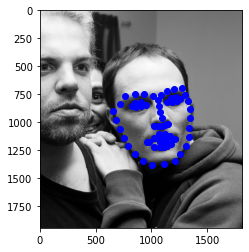

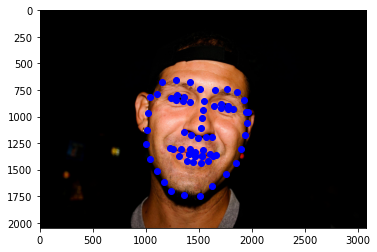

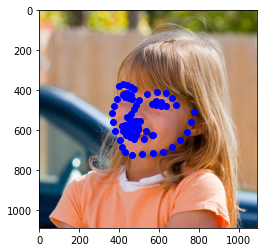

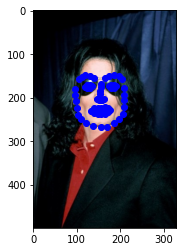

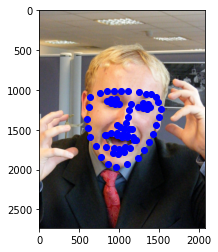

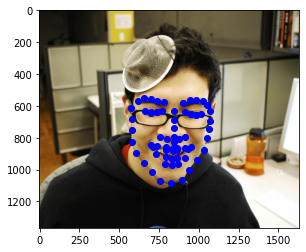

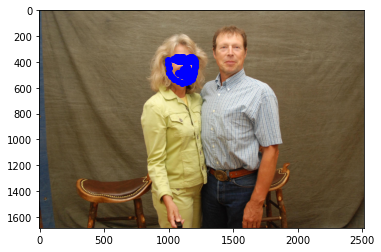

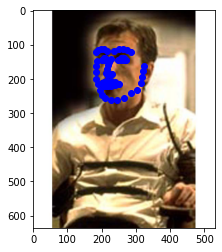

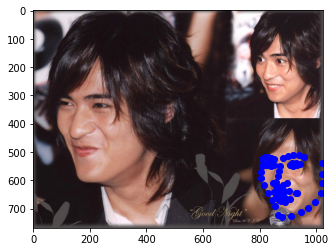

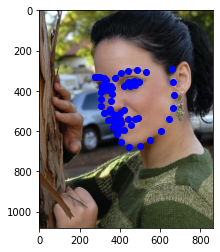

In [3]:
# img Paths parsing
paths = []
with open('data/300w_train_images.txt', 'r') as f:
  for line in f:
    paths.append('data/' + line)


  
affiche(paths, np.random.randint(0,len(paths), 10))


    

# 1.3 Augmentation des données

In [4]:
def boite_engl(path ,im_shape, elargir = 0.3):  
  pts = parsepts(path)
  h,w, _ = im_shape

  
  x_min = min(pts[:,0])
  y_min = min(pts[:,1])

  x_max =  max(pts[:,0])

  y_max =  max(pts[:,1])


  elarg_x = (x_max - x_min)*elargir/2
  elarg_y = (y_max - y_min)*elargir/2


  x_min = max(x_min -elarg_x, 0)
  x_max = min(x_max + elarg_x, w)

  y_min = max(y_min - elarg_y, 0)
  y_max = min (y_max + elarg_y, h)


  new_pts = pts.copy()
  new_pts[:,0]= new_pts[:,0] - x_min
  new_pts[:,1]= new_pts[:,1] - y_min

  return str2int([y_min, y_max, x_min, x_max]), new_pts


# im = load_img(paths[3])
# s, pts  = boite_engl(to_pts(paths[3]), im.shape, 0)
# plt.imshow(im)
# plt.scatter([s[2], s[2], s[3], s[3]], [s[0], s[1], s[0], s[1]] )

# s , pts  = boite_engl(to_pts(paths[3]), im.shape, 0.3)
# plt.scatter([s[2], s[2], s[3], s[3]], [s[0], s[1], s[0], s[1]] , color = "green")

# plt.show()




In [5]:
def resize_img(path, elargir = 0.3):
  """Centre les images sur le visage (boite englobante, puis resize les images en 128x128 en éditant également la poistions des points

  Args:
      path (str): path to images dataset 
      elargir (float, optional): Elargissement de la boite englobante. Defaults to 0.3.
  """
  im = load_img(path, rgb = False)

  # Boite englobante + elargissemtn de 30 %
  s, pts = boite_engl(to_pts(path), im.shape, elargir = elargir)
  im = im[s[0] : s [1], s[2] : s[3]]

  h,w ,_ = im.shape

  # Resizing
  im = cv.resize(im, (128,128), interpolation=cv.INTER_LANCZOS4)
  h2,w2 , _= im.shape

  # Nouvelle valeur des points
  pts[:,0] = np.uint64(pts[:,0]*w2/w)
  pts[:,1] = np.uint64(pts[:,1]*h2/h)
  
  return im, pts



# Redimensionnemnet de toute la base de données  et sauvegarde dans data/resized

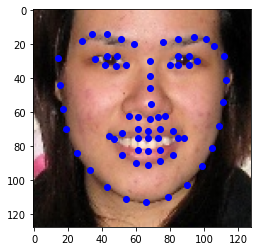

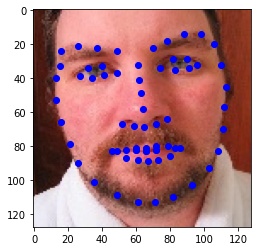

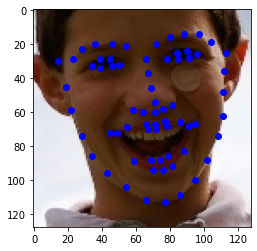

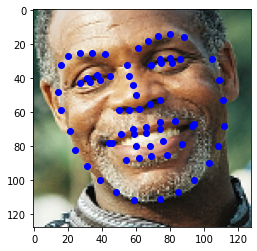

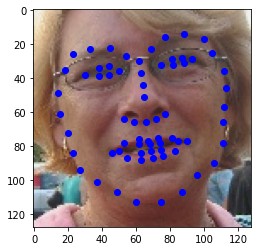

In [6]:
if not os.path.isdir("data/resized/train"):
    os.makedirs("data/resized/train")

    for n, p in enumerate(paths):
        # if n % 100 == 0:
        p = p.strip()
        print(f"{n} / {len(paths)}", end = '\r')


        im, pts = resize_img(p,elargir=0.3)

        name_index = p[::-1].index("/")
        name = p[len(p) - name_index:]
        cv.imwrite("data/resized/train/" + name, im)

        f = open("data/resized/train/" + to_pts(name), 'x')
        for i in pts:
            s = f"{i[0]} {i[1]}\n"
            f.write(s)
        f.close()
            

img_paths = sorted(glob.glob("data/resized/train/*g")) # On a des png et des jpg

#Test de la nouvelle base d'entrainement
affiche(img_paths,np.random.randint(0,len(img_paths), 5))


4. Calculer la position moyenne des points caractéristique sur l’ensemble des images de la
base d’apprentissage

In [7]:
pts_tab = []
for p in img_paths:
    pts_tab.append(parsepts(to_pts(p)))

mean_ld = np.mean(pts_tab, axis = 0, dtype = np.uint64)

5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en trans- lation et en facteur d’échelle) et enregistrer chacune de ces réalisations. L’amplitude de ces déformations sera de ±20% pour le facteur d’échelle et ±20px pour les translations (indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une méthode automatique pour déterminer l’amplitudes de ces déplacements ?



Ces transformations corespondent à de la data augmentaiton. Cela permet, avec une base de donnée limités, d'avoir un entrainemnet plus efficace. De plus ici on estime le model moyen sur toute la base de données. En appliquant des perturbations, le modèle apprendra à placer les points au bon endroit.

Une méthode automatique pour déterminer l'amplitude des déplacements des points caractéristiques consiste à utiliser l'analyse en composantes principales. L'ACP permet de trouver les directions de plus grande variation dans les positions des points caractéristiques. En utilisant ces informations, on peut déterminer l'amplitude des déplacements à appliquer aux points lors de la génération des perturbations aléatoires. C'est d'ailleurs ce qu'on verra par la suite.


In [55]:
perturbed_ld  = []
while (len(perturbed_ld) <10 ):
    #Transflation pixel

    randx = np.random.randint(-20,20)
    randy = np.random.randint(-20,20)

    new_mean = mean_ld.copy()  
    if len(perturbed_ld) < 5:
        new_mean[:,0] = new_mean[:,0] + randx
        new_mean[:,1] =  new_mean[:,1]  + randy
    

    #Transflation facteur d'échelle
    else:
        new_mean[:,0] = new_mean[:,0] + new_mean[:,0]*randx/100
        new_mean[:,1] = new_mean[:,1] +  new_mean[:,1]*randy/100


    # Verification que les points ne dépassetn pas la tailel des images
    if np.max(new_mean) <= 128 and np.min(new_mean) > 0: 
        perturbed_ld.append(new_mean)

        

Affichage des landmarks perturbés

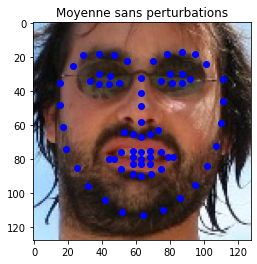

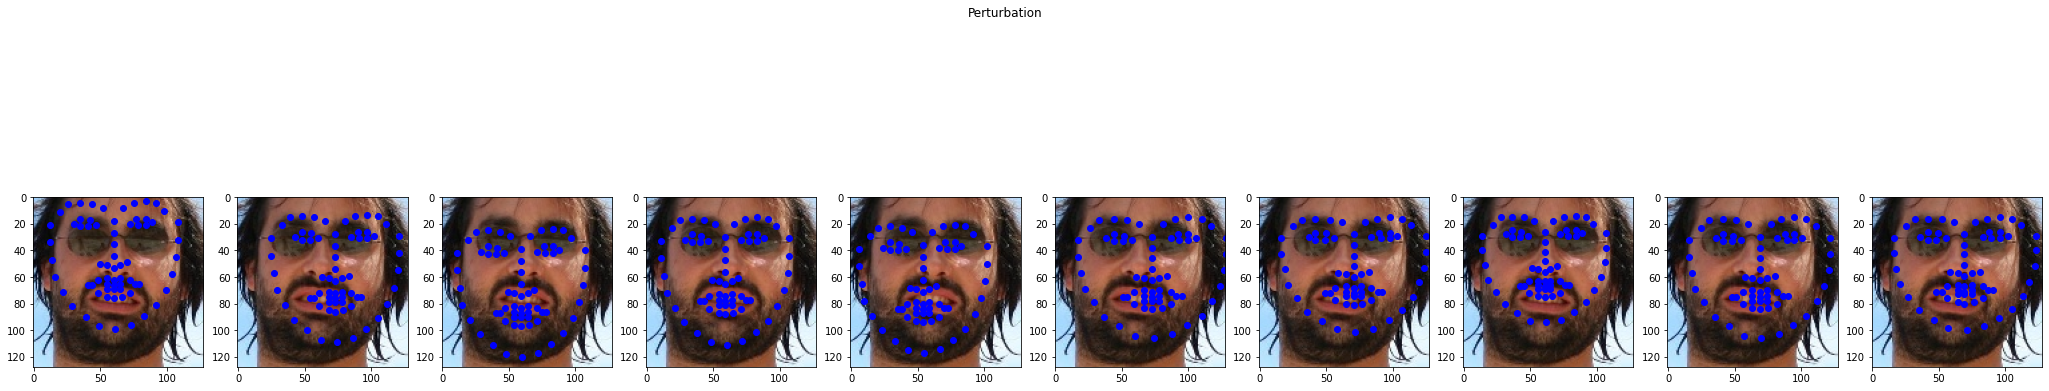

In [58]:

affiche(img_paths, 1, mean_ld, "Moyenne sans perturbations")
fig = plt.figure(figsize = (36,4))
fig.suptitle("Perturbation")

for i,p in enumerate(perturbed_ld):
    plt.subplot(1, len(perturbed_ld), i+1)
    affiche(img_paths, 1, p, newFig= False)


## 2.1 Extraction de caractéristiques image

1. Pourquoi ne peut-on pas utiliser directement les valeurs des pixels de l’image comme représentation?

Les valeurs des pixels ne sont pas des descripteurs suiffisant. La valeur d'un pixel (ici la peau) se retrouver plusieurs fois dans l'image et ne peut pas décrire correctement le point d'interet. En effet, la valeur des pixels est  très sensible aux changement de luminosité, de contraste et de perspective. Par exemlpe si le visage est observé sous un angle différent, la valeur des pixels varie beaucoup.

2. Créer, pour chaque point caractéristique courant du modèle moyen , un objet cv2.keyPoint en spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant le diamètre du voisinage) de 20 pixels.

In [10]:
keyPoints = []

for i in mean_ld:
    keyPoints.append(cv.KeyPoint(*np.float64(i), size = 20))



3. Utiliser la fonction sift.compute de opencv pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. Quel est la dimensionnalité de chacun de ces descripteurs?

In [11]:
sift = cv.SIFT_create()
im = load_img(img_paths[1])
kp, desc = sift.compute(image = im,keypoints= keyPoints)

print(f"La dimensionnalité de chacun des descripteurs est : {desc.shape[1]}")


La dimensionnalité de chacun des descripteurs est : 128


4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. Quelle est la dimension de ce descripteur?

Etant donné qu'on a 68 keypoints, la dimension attendue est 128*68 = 8704.


In [12]:
descriptors = []
for i, p in enumerate(img_paths):
    if i % 100 == 0:
        print(f"{i} / {len(img_paths)}", end = '\r')
    im = load_img(p)
    kp, desc = sift.compute(image = im, keypoints = keyPoints)
    descriptors.append(desc.flatten())

In [13]:
print(descriptors[1].shape)

(8704,)


On retrouve bien la dimensions attendu.

5. Citer deux exemples de représentation image qui pourraient être utilisés à la place des descripteurs SIFT, en expliquant brièvement le principe sous-jacent.


On aurait pu utilser par exmeple le local binary pattern, un descripteur puisant et rapide a calculer : \
    - Dans un voisinage circulaire au point d'interet on considère n points\
    - On regarde pour chaque voisin la valeur du pixel pa r rapport au pixel central, on mets 1 si c'est supérieur, 0 sinon\
    - On Concatèen ensuite ces valeurs pour former un code binaire LBP.\


Deuxieme methode, un histograme de gradient : HoG:

 
Dans cette methode on utilise le gradient pour avoir l'information de l'orientation du pixel. On obtient un histogramme qui nous permet de décrire le milieu .



## 2.2 Réduction de dimensionalité

1. Quel est l’intérêt principal de la réduction de dimensionalité en machine learning? Quelles sont les principales méthodes de réduction de dimensionalité?


Réduire la dimensionalité permet d'augmeneter drastiquemnet le temps de calcul. Il faut que cela se fasse sans perte d'efficacité.
De plus en réduisant la dimensions, on supprime un grand nombre d'information pour ne garder que les plus importante, ce qui réduit la compléxité du modèle et rend par conséquent l'entrainement plus efficace.

l'ACP ne considère que les dimensions de grande importance.

2. Utiliser l’analyse en composante principale (ACP ou PCA en anglais - librairies opencv ou skimage, au choix) en conservant 98% de la variance totale des descripteurs.

In [14]:
from sklearn.decomposition import PCA

# 98 % de la variance
pca = PCA(svd_solver='full', n_components= 0.98)
X0 = descriptors

pca.fit(X0)


PCA(n_components=0.98, svd_solver='full')

3. Quelles sont les dimensions de la matrice X̃0 obtenue par réduction de dimensionalité?

In [15]:
X0_t = pca.transform(X0)
A0 = pca.components_
# X0_t = np.dot(X0  pca.mean_, A0)

print(X0_t.shape)

(3148, 251)


Au final, la dimension de chaque images est de 251.
On divise par 34 la dimensions d'origine ! 


## 2.3 Estimation du déplacement


1. Calculer la matrice Ỹ0 , la matrice de déplacements δs ∗ .

In [16]:
Y0 = np.zeros((len(img_paths), 136))
for i, path in enumerate(img_paths):
    groud_truth = parsepts(to_pts(path))
    Y0[i, :] = groud_truth.flatten() - mean_ld.flatten()



2. Calculer R 0 en appliquant une résolution aux moindres carrés et le déplacement R0 ̂X̃0 pour chaque image (ou chaque ligne).

In [17]:

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

regressor.fit(X0_t, Y0)

R0 = regressor.coef_


dis = np.dot(X0_t, R0.T)
print(dis.shape)

(3148, 136)


3. Calculer l’erreur δs∗ − R0 Ỹ0 et afficher, pour la première image de la base, les points caractéristiques initiaux s 0 (en vert) ainsi que les points déplacées s0 + δs. Que peut-on en conclure?

In [18]:
error  = Y0 - dis
# On puet également calcule la MSE pour chaque ligne  
print("erreur maximale en pixel :",np.max(abs(error)))
print("erreur moyenne en pixel :", np.mean(abs(error)))

erreur maximale en pixel : 36.5924574896916
erreur moyenne en pixel : 2.693045589965563


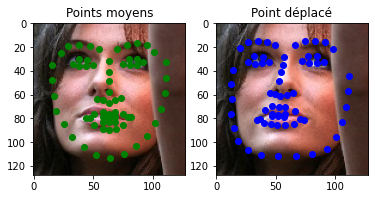

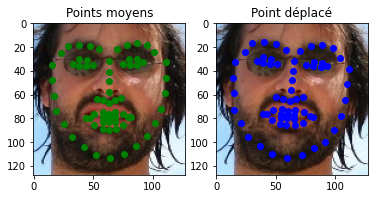

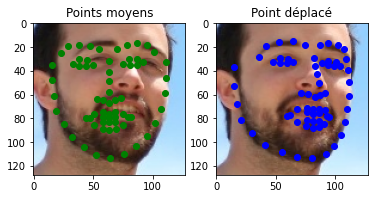

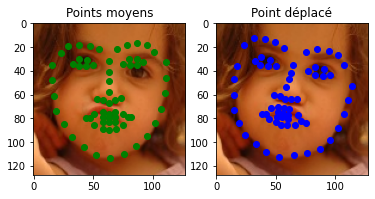

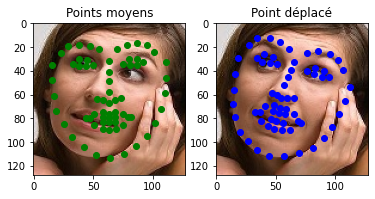

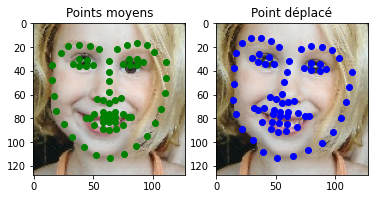

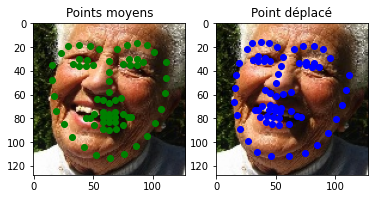

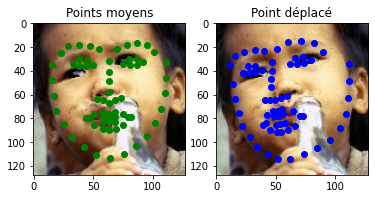

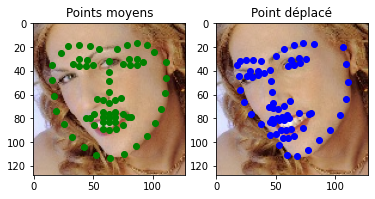

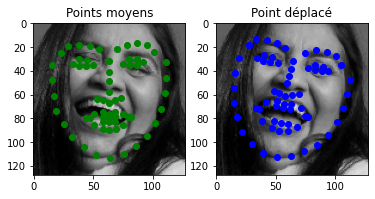

In [19]:

ds = X0_t @ R0.T


i = 0
for i in range(10):
    plt.figure()
    plt.subplot(1,2,1)
    affiche(img_paths, i, mean_ld,   pts_color = "green", title=  "Points moyens", newFig=False)

    plt.subplot(1,2,2)
    affiche(img_paths, i, mean_ld + ds[i].reshape(68,2),   pts_color = "blue", title=  "Point déplacé", newFig = False)
    plt.show()


Comme on peut le voir, le modèle apprsi par régression linéaire à tenté de réajuster les points du modèle moyen pour qu'il s'adapte au visage. Le réajustement n'est pas parfait (par exemple l'oeil droit) mais il est largement satisfaisant

## 2.4 Validation sur un ensemble de test externe 

A partir d’une position de départ s<sub>0</sub>, les matrices A<sub>0</sub> et R<sub>0</sub> apprises respectivement par ACP et régression aux moindres carrés définissent le modèle d’alignement de points caractéristiques. Etant donné une nouvelle image, l’alignement est effectué en extrayant les descripteurs SIFTs autour de chaque point (en s<sub>0</sub>), en compressant cette représentation (multiplication matricielle par A<sub>0</sub>), en ajoutant le terme de biais permettant d’obtenir Ỹ<sub>0</sub>, puis en appliquant une multipli- cation matricielle par R<sub>0</sub>. Il conviendra donc d’enregistrer les valeurs contenues dans s<sub>0</sub> (forme moyenne), A<sub>0</sub> (matrice de projection de l’ACP), et R<sub>0</sub> (coefficients des régressions linéaires).

1. En quoi l’évaluation précédente n’est-elle pas pertinente pour évaluer la capacité de général-
isation de la procédure d’alignement de points caractéristiques?

L'évaluation précédente n'est pas pertinente pour évaluer la capacité de généralisation de la procédure d'alignement de points caractéristiques car elle ne prend en compte qu'une seule image de la base de données. De plus on utilise uen image de la **base d'entrainement** sur lequel le modèle s'est entrainé ! \
Pour évaluer la capacité de généralisation de la procédure, il serait nécessaire de l'appliquer à plusieurs images de la base de test et de comparer les résultats obtenus avec la vérité terrain. Cela permettrait de mesurer l'exactitude de l'alignement pour différentes images et de déterminer si la procédure est capable de généraliser son alignement à des images qui ne font pas partie de la base de d'entraînement.

2. Calculer l’erreur $\delta^*_s - R_0 \times \hat{X}_0$ sur le set de test et afficher, pour la première image de la base, les points caractéristiques initiaux $s_0$ (en vert) ainsi que les points déplacées $s_0 + \delta^*_s$. Que peut-on en conclure?


On doit dans un premier temps appliquer les memes étapes de prétraitement de la base de test.

## Redimensionnement de la base de test

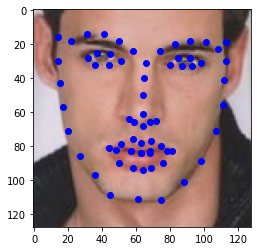

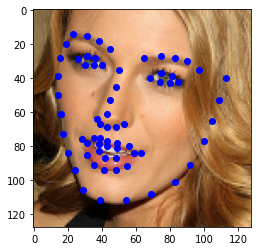

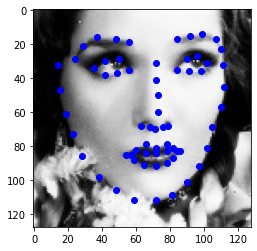

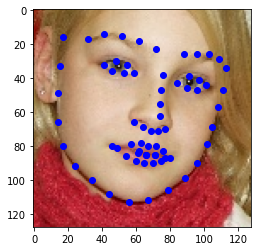

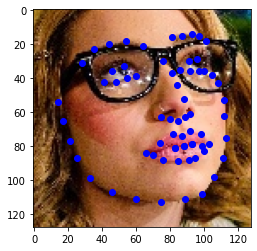

In [20]:
img_test_set = glob.glob("data/*/testset/*g")

if not os.path.isdir("data/resized/test"):
    os.makedirs("data/resized/test")

    for n, p in enumerate(img_test_set):
        # if n % 100 == 0:
        p = p.strip()
        print(f"{n} / {len(img_test_set) -1}", end = '\r')


        im, pts = resize_img(p,elargir=0.3)

        name_index = p[::-1].index("/")
        name = p[len(p) - name_index:]
        cv.imwrite("data/resized/test/" + name, im)

        f = open("data/resized/test/" + to_pts(name), 'x')
        for i in pts:
            s = f"{i[0]} {i[1]}\n"
            f.write(s)
        f.close()
        

img_test_paths = sorted(glob.glob("data/resized/test/*g")) # On a des png et des jpg

#Test de la nouvelle base d'entrainement
affiche(img_test_paths,np.random.randint(0,len(img_test_paths), 5))

In [21]:
# Calcul de la matrice de déplacement sur la base de test
test_Y0 = np.zeros((len(img_test_paths), 136))
for i, path in enumerate(img_test_paths):
    groud_truth = parsepts(to_pts(path))
    test_Y0[i, :] = groud_truth.flatten() - mean_ld.flatten()


X0_test = []
for i, p in enumerate(img_test_paths):
    if i % 100 == 0:
        print(f"{i} / {len(img_test_paths)}", end = '\r')
    im = load_img(p)
    kp, desc = sift.compute(image = im, keypoints = keyPoints)
    X0_test.append(desc.flatten())



print(f"La dimensionnalité de chacun des descripteurs est : {desc.shape[1]}")
# pca.transform fait une multiplication matricielle entre A0 est les descripteurs de test
X0_t_test = pca.transform(X0_test)
print("les dimensions de la matrice compressée des données est ", X0_t_test.shape)


La dimensionnalité de chacun des descripteurs est : 128
les dimensions de la matrice compressée des données est  (554, 251)


In [22]:
test_error = test_Y0 - X0_t_test @ R0.T
print("erreur maximale en pixel sur la base de test :",np.max(abs(test_error)))
print("erreur moyenne en pixel sur la base de test :", np.mean(abs(test_error)))


erreur maximale en pixel sur la base de test : 32.2940415270514
erreur moyenne en pixel sur la base de test : 2.645497950214671


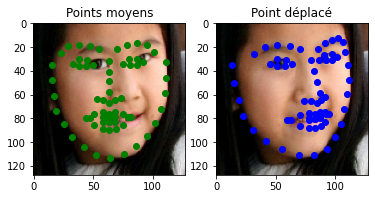

In [23]:
ds_test = X0_t_test @ R0.T

i = 0
plt.figure()
plt.subplot(1,2,1)
affiche(img_test_paths, i, mean_ld,   pts_color = "green", title=  "Points moyens", newFig=False)

plt.subplot(1,2,2)
affiche(img_test_paths, i, mean_ld + ds_test[i].reshape(68,2),   pts_color = "blue", title=  "Point déplacé", newFig = False)

Le modèle semble fonctionner sur la première image de la base de test, une image que le modèle n'a jamais vu pour l'entrainement.\

Ici on a vu qu'une seule image, on ne peut rien conclure sur la qualité de l'apprentissage.

On l'a vu, l'erreur absolue moyenne est d'environ 2 pixel. C'est satisfaisant.

Le mieux est d'afficher plusieurs images aléatoirement pour voir visuellement la qualité du model.


(10,)


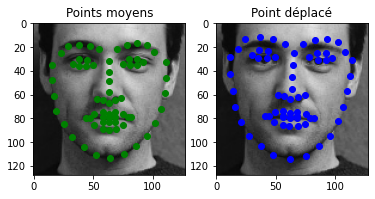

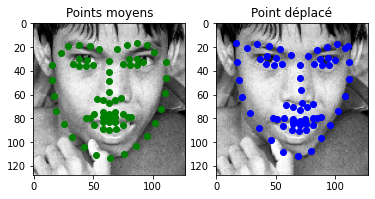

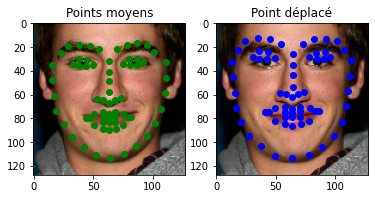

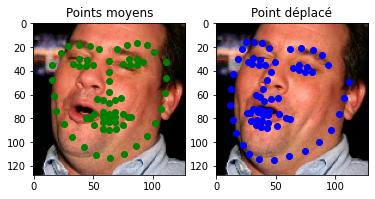

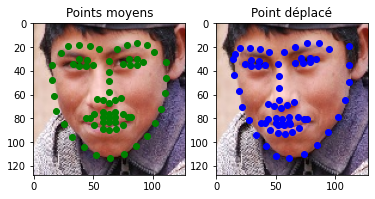

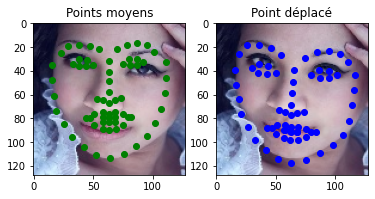

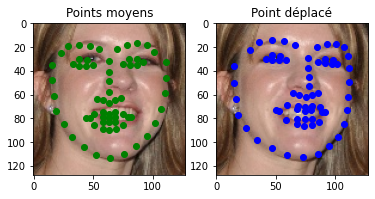

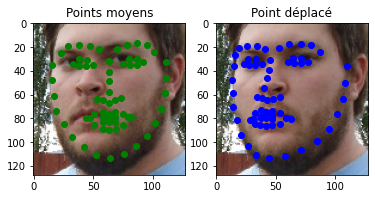

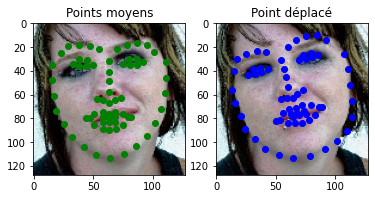

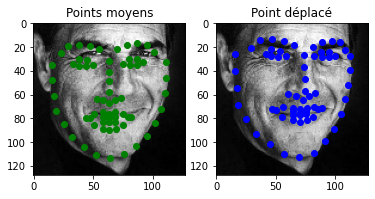

In [24]:
random_indices = np.random.randint(0,len(img_test_paths), 10)
print(random_indices.shape)
for i in random_indices:
    i = int(i)

    plt.figure()
    plt.subplot(1,2,1)
    affiche(img_test_paths, i, mean_ld,   pts_color = "green", title=  "Points moyens", newFig=False)

    plt.subplot(1,2,2)
    affiche(img_test_paths, i, mean_ld + ds_test[i].reshape(68,2),   pts_color = "blue", title=  "Point déplacé", newFig = False)
    plt.show()

De manière générale, le modèle est bon, il arrive à replacer les landmarks de manière satisfaisante sur des images qu'il n'a jamais vu, a partir du modèle moyen.

On peut en conclure que l'apprentissage effectué sur la base d'entrainement. R0 et A0 sont suffisement 'fiable' mais il existe encore une erreur significative qui pourrai être réduite. On le voit sur certains exemples l'alignemetn n'est pas encore parfait

## 3 Bonus : Cascade de régresseurs
Nous avons, dans la partie précédente, extrait des caractéristiques locales robustes (SIFT) à partir de l'image, réduit la dimension de ces descripteurs et appris un modèle de régression linéaire permettant d'estimer un déplacement $\delta s_0 = R_0 \tilde{X_0}$. Toutefois, l'erreur résiduelle d'apprentissage $\delta s^* - R_0 \tilde{X_0}$ est toujours significative. Afin de réduire davantage cette erreur, une solution consiste à itérer le processus mis en place à la partie 2, c'est-à-dire d'appliquer itérativement toutes les étapes vues plus haut à partir du déplacement du modèle $s_1 = s_0 + \delta s_0$ afin d'apprendre un déplacement $\delta s_1$, puis $\delta s_2$ à partir de $s_2 = s_1 + \delta s_1$, et ainsi de suite.

### 3.1 Itération du processus d'alignement
1. Ecrire une fonction majPoints qui, à l'itération $k+1$, calcule la position des nouveaux points caractéristiques étant donné une position initiale $s_k$ et un déplacement $\delta s_k$.

In [25]:
def majPoints(s, delta_s):
    s = s.copy()
    if np.array_equal(s.shape, [68,2]):
        s = s.flatten()

    res = s + delta_s

    return  res
    


2. Ecrire une fonction oneStepAlignment qui calcule les étapes 2.1, 2.2, 2.3 ainsi que la question 1 du 3.1 précédente.

In [26]:

# Calcul de la matrice de déplacement sur la base de test


def oneStepAlignment(s0, paths = img_test_paths, k = None):
    """Fait toutes les étapes pour calculer un déplacement, retourne les nouveaux points

    Args:
        s0 (ndarray):  
        paths (ndarray, optional): Tableau contenant tous les chemain des image. Defaults to img_test_paths.
        k (_type_, optional): Nombre d'itteration pour l'affichage. Defaults to None.

    Returns:
        _type_: _description_
    """
    keypoints_i = None
    keyPoints = []
    if s0.shape[1] == 2:
        for i in s0:
            keyPoints.append(cv.KeyPoint(*np.float64(i), size = 20))
    else:
        keypoints_i = []
        for points in s0:
            points = points.reshape(68,2)
            keyPoints = []
            for i in points:
                keyPoints.append(cv.KeyPoint(*np.float64(i), size = 20))
            keypoints_i.append(keyPoints)



    # Calcul des descripteurs SIFT sur toute les images
    X0 = []
    for i, p in enumerate(paths):
        if i % 100 == 0:
            print(f"{i} / {len(paths)}", end = '\r')
        im = load_img(p)
        if s0.shape[1] == 2:
            kp, desc = sift.compute(image = im, keypoints = keyPoints)
        else:
            kp, desc = sift.compute(image = im, keypoints = keypoints_i[i])

        X0.append(desc.flatten())

    # Reduciton de dimension : 
    print("Reduction des dimensions", end ="\r")
    pca = PCA(svd_solver='full', n_components= 0.98)
    pca.fit(X0)
    A0 = pca.components_
    X0_t = pca.transform(X0)

    # Estimation dnu déplacmenet

    Y0 = np.zeros((len(paths), 136))
    for i, path in enumerate(paths):
        groud_truth = parsepts(to_pts(path))
        if s0.shape[1] == 2:
            Y0[i, :] = groud_truth.flatten() - s0.flatten()
        else: 
            Y0[i,:] = groud_truth.flatten() - s0[i,:]

    print("linar regression", end = "\r")
    regressor = LinearRegression()
    regressor.fit(X0_t, Y0)
    R0 = regressor.coef_
    ds = X0_t @ R0.T


    error = error  = Y0 - ds
    print(f"erreur maximale en pixel pour l'ittération {k if k is not None else '?'} :",np.max(abs(error)))
    print(f"erreur moyenne en pixel pour l'ittération {k if k is not None else '?'} :", np.mean(abs(error)))

    # A la première itération s0 est de la forme (68,2), ensuite il aura une dimension suplémentaire qui correspondra au nombre d'image
    if keypoints_i is None :
        return majPoints(s0,ds), pca, R0, error, keyPoints
    else:
        return majPoints(s0,ds), pca, R0, error, keypoints_i



    

3. Appliquer itérativement k = 5 fois la Fonction oneStepAlignment à partir de $s_0$. Le vecteur $s_0$, ainsi que les matrices $A_k$ et $R_k$ pour $k = 0 \dots 4$ seront sauvegardées.

4. Evaluer les 5 modèles $k = 0 \dots 4$ et afficher, pour la première image de la base, les points caractéristiques initiaux $s_k$ (en vert) ainsi que les points déplacées $s_k + \delta s_k$. Que peut-on en conclure?

In [27]:

sk = mean_ld.copy()
saved_matrices = []
for k in range(5):
    print("------")
    sk, pcak , Rk, error, kp= oneStepAlignment(sk, img_paths, k)
    saved_matrices.append((sk, pcak, Rk, error,kp))




# affiche(img_test_paths, i, s0[i].reshape(68,2),   pts_color = "blue", title=  "Point déplacé")

------
erreur maximale en pixel pour l'ittération 0 : 36.5924574896916
erreur moyenne en pixel pour l'ittération 0 : 2.693045589965563
------
erreur maximale en pixel pour l'ittération 1 : 31.350870204428695
erreur moyenne en pixel pour l'ittération 1 : 1.879853691844871
------
erreur maximale en pixel pour l'ittération 2 : 30.09022387911852
erreur moyenne en pixel pour l'ittération 2 : 1.7636293604571387
------
erreur maximale en pixel pour l'ittération 3 : 30.00462762670597
erreur moyenne en pixel pour l'ittération 3 : 1.7407269231565021
------
erreur maximale en pixel pour l'ittération 4 : 29.878019115936766
erreur moyenne en pixel pour l'ittération 4 : 1.734768795077229


En 5 itérations, la moyenne de l'erreur absolue à baisse de 1 pixel. Cependant au vu des erreur des ancienne itérations, 1.73 semble ne pas être loin de la convergeance.\
On va mainteant afficher les images

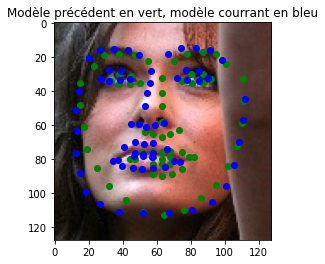

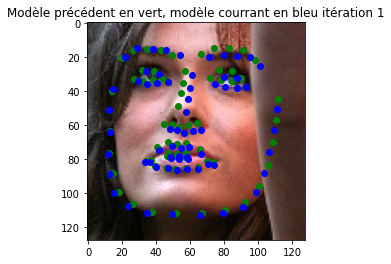

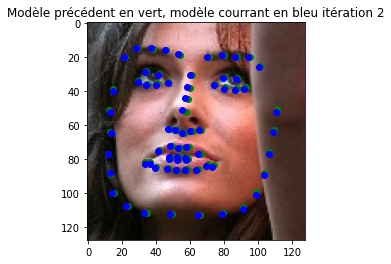

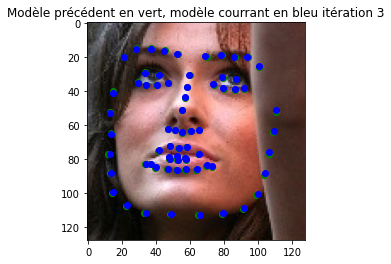

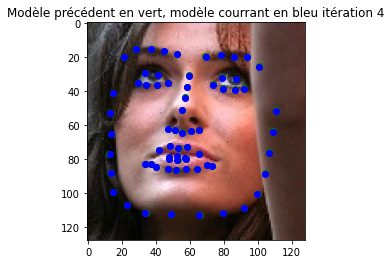

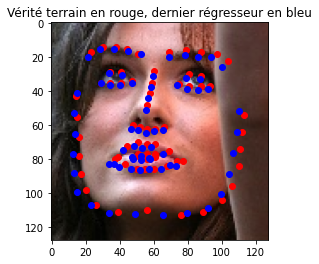

In [28]:
sk = mean_ld.copy()
for k, matrices in enumerate(saved_matrices):

    i = 0
    plt.figure()
    if k == 0:

        affiche(img_paths, i, sk.reshape(68,2),   pts_color = "green", title=  "Modèle précédent en vert, modèle courrant en bleu", newFig=False)
    else:
        affiche(img_paths, i, sk[i].reshape(68,2),   pts_color = "green", title=  f"Modèle précédent en vert, modèle courrant en bleu itération {k}", newFig=False)

    sk = matrices[0]
    trace_pts(sk[i].reshape(68,2), "blue")
    plt.show()


plt.figure()

affiche(img_paths, i, pts_color = "red", title=  "Vérité terrain en rouge, dernier régresseur en bleu", newFig=False)
trace_pts(saved_matrices[-1][0][i].reshape(68,2), "blue")


Comme on le voit, le modèle converge petit à petit vers une solution satisfaisante. La dernière image met en opposition la vérité terrain en rouge et le regresseur le plus entrainé en bleu. Les points ne sont pas très éloignés.

Il reste cependant que ce test à été fait sur la base d'entrainement, il serait plus judicieux de le faire sur la base de test.


5. Évaluer les 5 modèles $k = 0 \dots 4$ sur le set de test et afficher, pour la première image de la base, les points caractéristiques initiaux $s_k$ (en vert) ainsi que les points déplacées $s_k + \delta s_k$. Que peut-on en conclure?


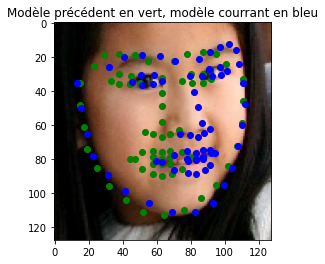

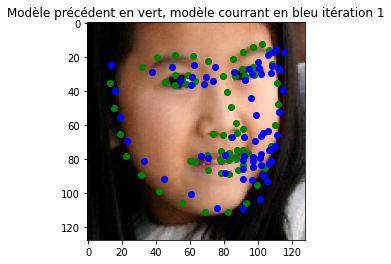

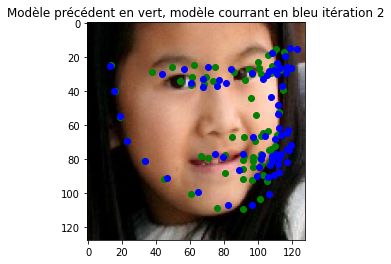

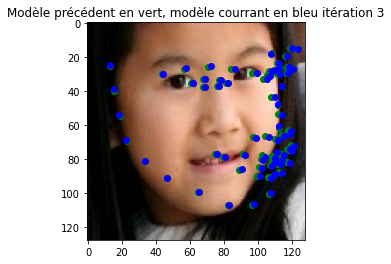

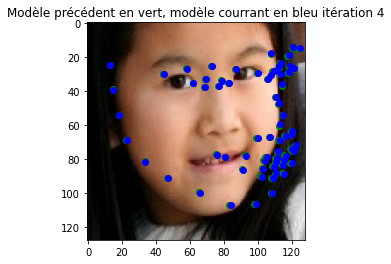

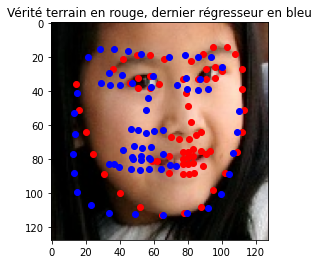

In [54]:
sk = mean_ld.copy()
sk = sk.flatten()
for k, matrices in enumerate(saved_matrices):
    pcas = matrices[1]
    Rk = matrices[2]
    keyPk = matrices[4]

    X0_test_k = []
    for i, p in enumerate(img_test_paths):
        if i % 100 == 0:
            print(f"{i} / {len(img_test_paths)}", end = '\r')
        im = load_img(p)
        if len(keyPk) == 68:
            kp, desc = sift.compute(image = im, keypoints = keyPk)
        else:
            kp, desc = sift.compute(image = im, keypoints = keyPk[i])


        X0_test_k.append(desc.flatten())

    X0_t_test_k = pcas.transform(X0_test_k)
    ds_test_k = X0_t_test_k @ Rk.T
    old_sk = sk
    sk = sk + ds_test_k

    i = 0
    plt.figure()
    if k == 0:

        affiche(img_test_paths, i, mean_ld,   pts_color = "green", title=  "Modèle précédent en vert, modèle courrant en bleu", newFig=False)
        trace_pts(sk[i].reshape(68,2), "blue")
    else:
        affiche(img_test_paths, i, old_sk[i].reshape(68,2),   pts_color = "green", title=  f"Modèle précédent en vert, modèle courrant en bleu itération {k}", newFig=False)
        trace_pts(sk[i].reshape(68,2), "blue")


    plt.show()



plt.figure()

affiche(img_test_paths, i, pts_color = "red", title=  "Vérité terrain en rouge, dernier régresseur en bleu", newFig=False)
trace_pts(saved_matrices[-1][0][i].reshape(68,2), "blue")



POur une raison que je ne comprends pas ça ne fonctionne pas sur la base de test, je n'ai pas l'email du prof 